In [1]:

#UTILITIES
import pandas as pd 
import numpy as np 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from ast import literal_eval
import itertools
import time
import re
import math
import scipy.stats as stats

#MACHINE LEARNING
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

#MAKE CHARTS PRETTY
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial'],'size':'14'}) 

#Some Settings

pd.set_option('display.max_columns', 100)

RANDOM_STATE = len('I used to be an adventurer like you But I took an Arrow to the knee') 

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Data import

#Kaggle Dataset of 200k steam games by user (this will be used for recommendations)
steam_200k = pd.read_csv('data/Kaggle/steam-200k.csv')
#Dataset gathered using steam API
steam_clean = pd.read_csv('steam_clean.csv')
#metacritic filtered from steam API
metacritic_clean = pd.read_csv('metacritic_clean.csv')

In [3]:
steam_clean.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,0,159745,4173,21211,172,10000000-20000000,9.99
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,0,4335,771,798,11,2000000-5000000,4.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,4325,482,894,18,5000000-10000000,4.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Classic,0,1592,345,1200,8,5000000-10000000,4.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Classic,0,8907,477,1316,281,5000000-10000000,4.99


In [4]:
metacritic_clean.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,meta_score,total_recommendations,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,0,159745,4173,88,92459,21211,172,10000000-20000000,9.99
1,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,4325,482,79,2634,894,18,5000000-10000000,4.99
2,70,Half-Life,1998-11-08,1,Valve,Valve,windows;mac;linux,0,Single-player;Multi-player;PvP;Online PvP;Stea...,Action,FPS;Classic;Action,0,48358,1819,96,37530,2632,184,5000000-10000000,9.99
3,80,Counter-Strike: Condition Zero,2004-03-01,1,Valve,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,Action;FPS;Shooter,0,15679,1606,65,11945,1820,23,5000000-10000000,9.99
4,130,Half-Life: Blue Shift,2001-06-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Remote Play Together,Action,FPS;Action;Sci-fi,0,6439,672,71,5466,1317,191,5000000-10000000,4.99


In [5]:
metacritic_clean['english'].value_counts()

1    3171
0       3
Name: english, dtype: int64

In order to create a model for metacritic scores, we need to create a corresponding user score. We'll use steamDB's user score method which utilizes the positive and negative ratings given by users on steam to create a score.

### Light Feature Engineering

https://steamdb.info/blog/steamdb-rating/



In [6]:
def remove_non_english(df):
    # keep only rows marked as supporting english
    df = df[df['english'] == 1].copy()
    # keep rows which don't contain 3 or more non-ascii characters in succession
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]
    # remove english column, now redundant
    df = df.drop('english', axis=1)
    return df
def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math
    pos = row['positive_ratings']
    neg = row['negative_ratings']
    total_reviews = pos + neg
    average = pos / total_reviews
    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))
    return score * 100
def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

In [7]:
def process_cat_gen_tag(df):
    """Process categories, genres and steamspy_tags columns."""
    # get all unique category names
    cat_cols = get_unique(df['categories'])
    # only going to use these categories (can uncomment to use others)
    cat_cols = [
        # 'Local Multi-Player',
        # 'MMO',
        'Mods',
        'Multi-player',
        'Online Co-op',
        'Online Multi-Player',
        'Single-player'
    ]
    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
    # repeat for genre column names (get_unique used to find unique genre names, 
    # not necessary but useful if keeping all of them)
    gen_cols = get_unique(df['genres'])
    # only keeping 'main' genres similar to steam store
    gen_cols = [
        # 'Accounting',
        'Action',
        'Adventure',
        # 'Animation & Modeling',
        # 'Audio Production',
        'Casual',
        # 'Design & Illustration',
        # 'Documentary',
         'Early Access',
        # 'Education',
        # 'Free to Play',
        # 'Game Development',
        # 'Gore',
        'Indie',
        'Massively Multiplayer',
        # 'Nudity',
        # 'Photo Editing',
        'RPG',
        'Racing',
        # 'Sexual Content',
        'Simulation',
        # 'Software Training',
        'Sports',
        'Strategy'
        # 'Tutorial',
        # 'Utilities',
        # 'Video Production',
        # 'Violent',
        # 'Web Publishing'
    ]
    gen_col_names = []
    
    # create new columns for each genre with 1s for games of that genre
    
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()
    
    
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    return df


In [8]:
def pre_process(df):
    """Preprocess Steam dataset for exploratory analysis."""
    
    # keep english only
    df = remove_non_english(df)
    # keep windows only, and remove platforms column
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()
    # keep lower bound of owners column, as integer
    df['owners'] = df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)
    # calculate rating, as well as simple ratio for comparison
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)
    # convert release_date to datetime type and create separate column for release_year
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    # process genres, categories and steamspy_tag columns
    df = process_cat_gen_tag(df)
    return df

In [9]:
data = pre_process(metacritic_clean)
print('Verify no missing values:')
print(data.isnull().sum().value_counts())
data.head()

Verify no missing values:
0    36
dtype: int64


,appid,name,release_date,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,meta_score,total_recommendations,average_playtime,median_playtime,owners,price,total_ratings,rating_ratio,rating,release_year,mods,multi_player,online_co_op,online_multi_player,single_player,action,adventure,casual,early_access,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,10,Counter-Strike,2000-11-01,Valve,Valve,0,Action,0,159745,4173,88,92459,21211,172,10000000,9.99,163918,0.974542,96.141982,2000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,30,Day of Defeat,2003-05-01,Valve,Valve,0,Action,0,4325,482,79,2634,894,18,5000000,4.99,4807,0.899730,86.467857,2003,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,70,Half-Life,1998-11-08,Valve,Valve,0,Action,0,48358,1819,96,37530,2632,184,5000000,9.99,50177,0.963748,94.521566,1998,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,80,Counter-Strike: Condition Zero,2004-03-01,Valve,Valve,0,Action,0,15679,1606,65,11945,1820,23,5000000,9.99,17285,0.907087,88.304644,2004,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,130,Half-Life: Blue Shift,2001-06-01,Gearbox Software,Valve,0,Action,0,6439,672,71,5466,1317,191,5000000,4.99,7111,0.905499,87.414454,2001,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


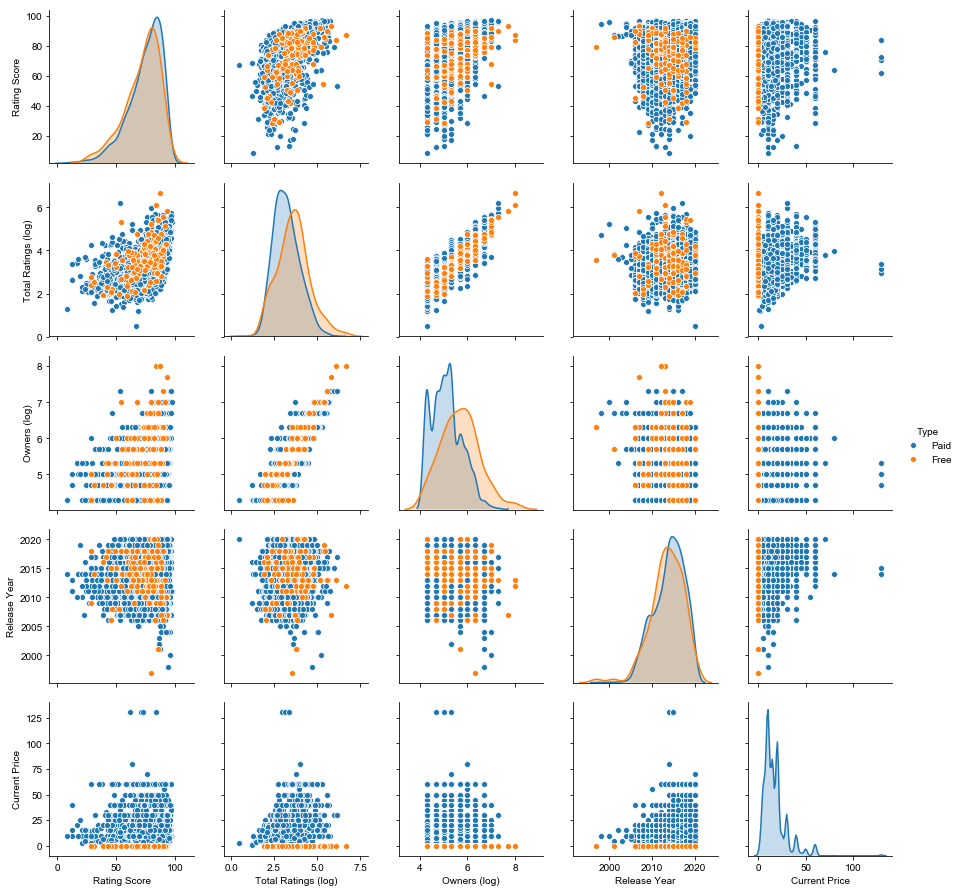

In [10]:
# Create a column to split free vs paid games
data['type'] = 'Free'
data.loc[data['price'] > 0, 'type'] = 'Paid'
# ensure no 0s in columns we're applying log to
df = data[(data['owners'] > 0) & (data['total_ratings'] > 0)].copy()
eda_df = pd.DataFrame(zip(df['rating'],
                          np.log10(df['total_ratings']),
                          np.log10(df['owners']),
                          df['release_year'],
                          df.price,
                          df['type']
                         ),
                      columns=['Rating Score', 'Total Ratings (log)', 'Owners (log)', 'Release Year', 'Current Price', 'Type'])
sns.pairplot(eda_df, hue='Type')
plt.show()


data.to_csv('processed_metacritic.csv')

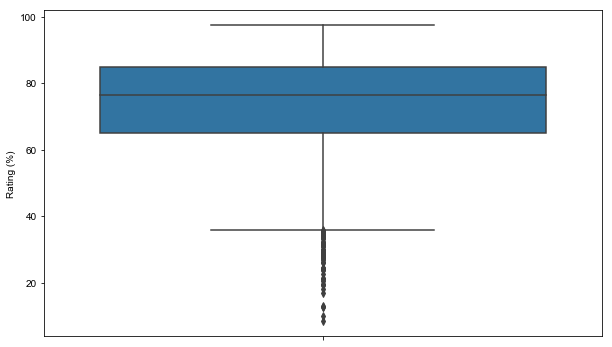

In [11]:
fig = plt.figure(figsize=(10,6))

ax = sns.boxplot(y='rating', hue= 'type', data = data)

ax.set(xlabel= '', ylabel = 'Rating (%)')
plt.show()

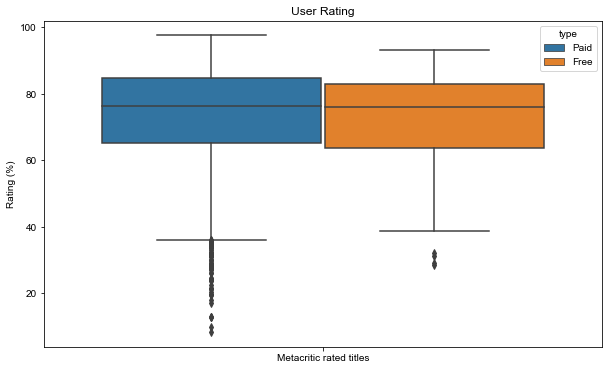

In [12]:
fig = plt.figure(figsize=(10,6))

df1 = data.copy()
df1['subset'] = 'Metacritic rated titles'
ax = sns.boxplot(x='subset', y='rating', hue='type', data=df1)
plt.title('User Rating')
ax.set(xlabel='', ylabel='Rating (%)')
plt.show()

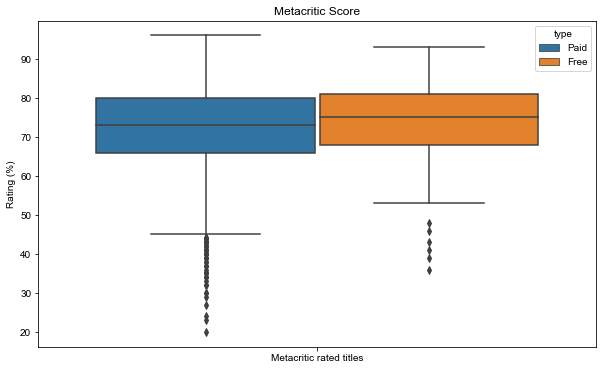

In [13]:
fig = plt.figure(figsize=(10,6))

df1 = data.copy()
df1['subset'] = 'Metacritic rated titles'
ax = sns.boxplot(x='subset', y='meta_score', hue='type', data=df1)
plt.title('Metacritic Score')
ax.set(xlabel='', ylabel='Rating (%)')
plt.show()

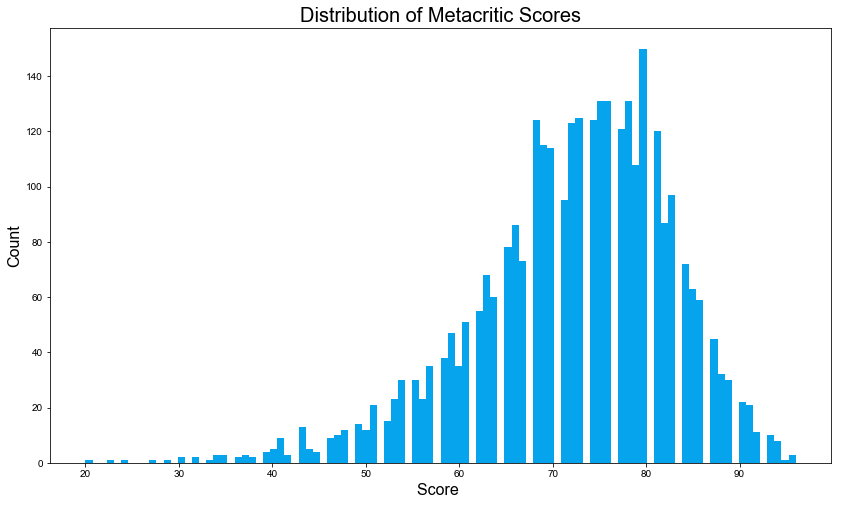

In [14]:
plt.figure(figsize=(14,8))
plt.hist(x = data['meta_score'],
         bins = 100,
         color = ['#05a4ed'])
plt.title('Distribution of Metacritic Scores', fontsize=20)
plt.xlabel('Score ', fontsize=16)
plt.ylabel('Count', fontsize=16);

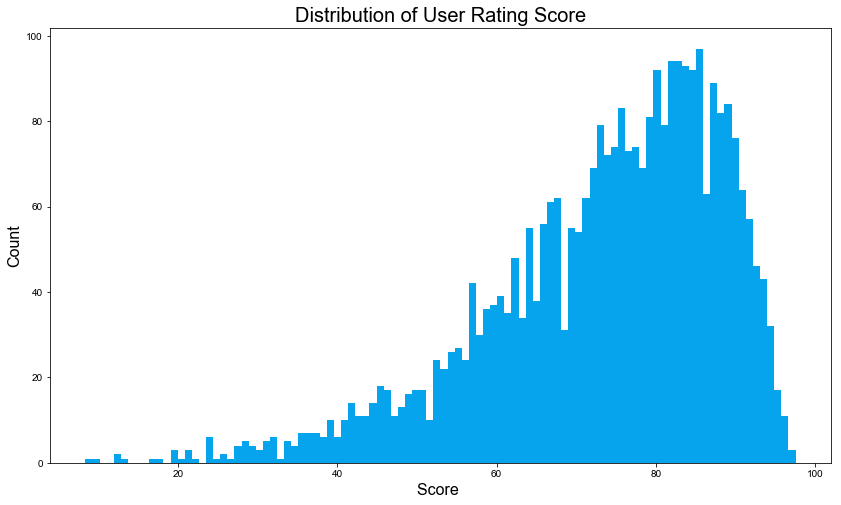

In [15]:
plt.figure(figsize=(14,8))
plt.hist(x = data['rating'],
         bins = 100,
         color = ['#05a4ed'])
plt.title('Distribution of User Rating Score', fontsize=20)
plt.xlabel('Score ', fontsize=16)
plt.ylabel('Count', fontsize=16);

In [16]:
data['meta_score'].describe()

count    3164.000000
mean       72.102402
std        10.712092
min        20.000000
25%        66.000000
50%        73.000000
75%        80.000000
max        96.000000
Name: meta_score, dtype: float64

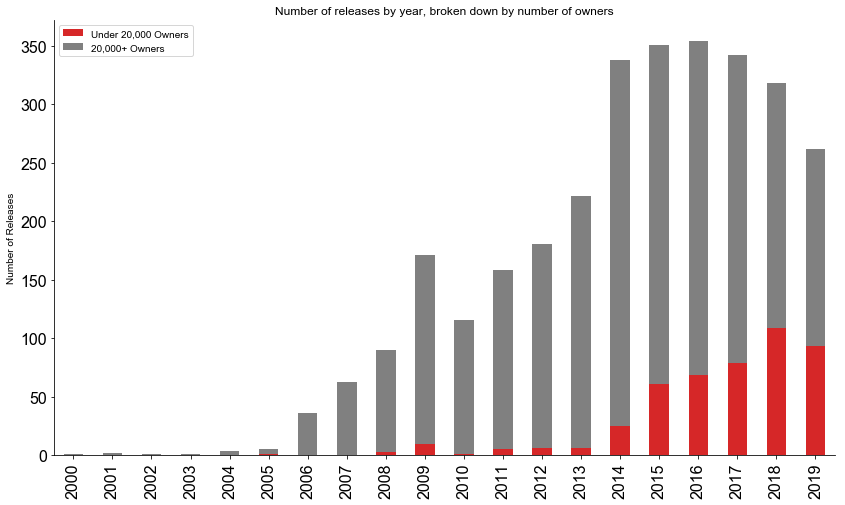

In [17]:
df = data.copy()
years = []
lt_20k = []
gt_20k = []
for year in sorted(df['release_year'].unique()):
    if year < 2000 or year > 2019:
        
        continue
    # subset dataframe by year
    year_df = df[df.release_year == year]
    # calculate total with less than 20,000 owners, and total with 20,000 or more
    total_lt_20k = year_df[year_df.owners < 20000].shape[0]
    total_gt_20k = year_df[year_df.owners >= 20000].shape[0]
    years.append(year)
    lt_20k.append(total_lt_20k)
    gt_20k.append(total_gt_20k)
owners_df = pd.DataFrame(zip(years, lt_20k, gt_20k), 
                         columns=['year', 'Under 20,000 Owners', '20,000+ Owners'])


ax = owners_df.plot(x='year', 
                    y=[1, 2], 
                    kind='bar', 
                    stacked=True, 
                    color=['tab:red', 'gray'],
                    figsize=(14,8),
                    fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Number of Releases')
ax.set_title('Number of releases by year, broken down by number of owners')
sns.despine()
plt.show()

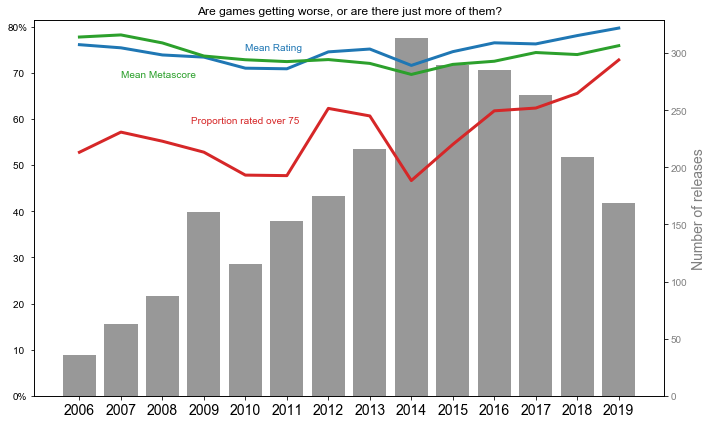

In [18]:
# Keeping games with only 20,000 owners or more
df = data[data.owners >= 20000].copy()
rating_threshold = 75
years = []
proportions = []
totals = []
avg_ratings = []
max_ratings = []
avg_metascores = []

# calculate values for plotting
for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2019:
        continue
    year_data = df[df['release_year'] == year]
    total = year_data.shape[0]
    n_high_rating = year_data[year_data['rating'] >= rating_threshold].shape[0]
    avg_rating = year_data['rating'].mean() / 100
    avg_metascore =year_data['meta_score'].mean() /100
    years.append(year)
    totals.append(total)
    proportions.append(n_high_rating/total)
    avg_ratings.append(avg_rating)
    avg_metascores.append(avg_metascore)
    # print(f'{year} | {n_high_rating/total:.2f}')
fig, ax1 = plt.subplots(figsize=(10,6))

# ensure lines drawn over bars
ax1.set_zorder(1)
ax1.patch.set_visible(False)


# plot trendlines
ax1.plot(avg_ratings, color='tab:blue', label='Average Rating', linewidth=3)
ax1.plot(proportions, color='tab:red', label=f'Proportion of games rated over {rating_threshold}', linewidth=3)
ax1.plot(avg_metascores, color='tab:green', label='Average Metascore', linewidth=3)
x_pos = np.arange(len(years))
ax1.set_xticks(x_pos)
ax1.set_xticklabels(years, fontsize=14)
ax1.set_yticks(np.arange(0, 0.9, 0.1))
ax1.set_yticklabels(['0%', '10 ', '20 ', '30 ', '40 ', '50 ', '60 ', '70 ', '80%'])

# instead of legend, place text directly over lines
ax1.text(4, 0.75, 'Mean Rating', color='tab:blue')
ax1.text(2.7, 0.59, 'Proportion rated over 75', color='tab:red')
ax1.text(1, 0.69, 'Mean Metascore', color='tab:green')

# allow multiple axis on same plot
ax2 = ax1.twinx()


# plot number of releases by year
color = 'tab:gray'
ax2.bar(x_pos, totals, color=color, alpha=.8)
ax2.set_ylabel('Number of releases', color=color, fontsize=14)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Are games getting worse, or are there just more of them?')
fig.tight_layout()
plt.show()

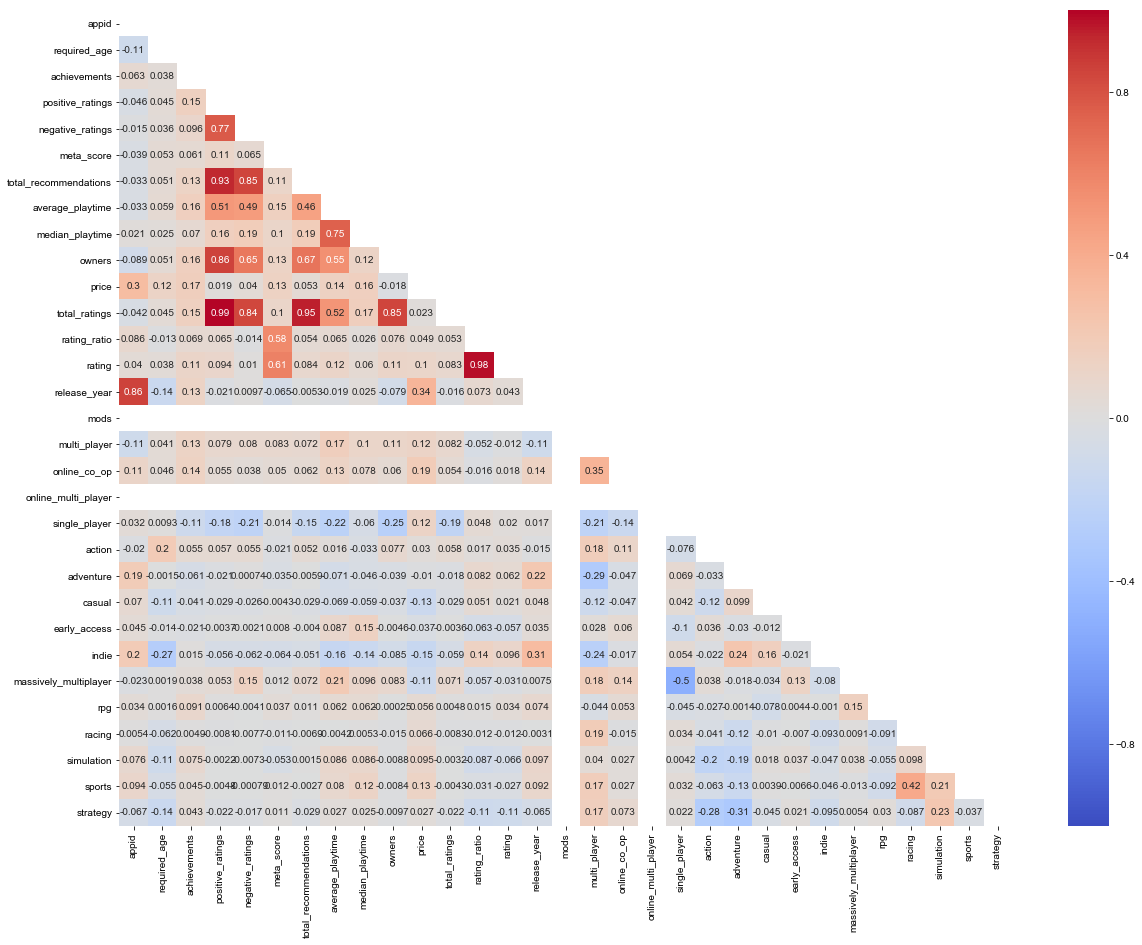

In [19]:
df= data
# Looking for multicollinearity
f, ax = plt.subplots(figsize=(20, 15))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)
plt.savefig('heatmap')

## Hypothesis Testing

In [20]:
import scipy.stats as stats
r, p_value = stats.pearsonr(data['meta_score'], data['median_playtime'])
# using rating_ratio - pretty similar result
# stats.pearsonr(totals, df.groupby('release_year').mean().rating_ratio.loc[2006:2018].values)
print(f'Correlation coefficient (r): {r}\np-value: {p_value}')

Correlation coefficient (r): 0.10239662333424555
p-value: 7.803170498260989e-09


## Feature Selection

In [21]:
df.columns

Index(['appid', 'name', 'release_date', 'developer', 'publisher',
       'required_age', 'genres', 'achievements', 'positive_ratings',
       'negative_ratings', 'meta_score', 'total_recommendations',
       'average_playtime', 'median_playtime', 'owners', 'price',
       'total_ratings', 'rating_ratio', 'rating', 'release_year', 'mods',
       'multi_player', 'online_co_op', 'online_multi_player', 'single_player',
       'action', 'adventure', 'casual', 'early_access', 'indie',
       'massively_multiplayer', 'rpg', 'racing', 'simulation', 'sports',
       'strategy', 'type'],
      dtype='object')

In [22]:
#features = ['rating', 'total_ratings', 'owners', 'price']
features = ['rating', 'total_recommendations',
       'average_playtime', 'median_playtime', 'owners', 'price',
       'total_ratings', 'rating_ratio']

In [23]:
X_df = df[features]
y = df['meta_score']

## Train Test Split


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.2, random_state = RANDOM_STATE
                                                   )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2531, 8), (633, 8), (2531,), (633,))

In [25]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

In [26]:

# Normalize using MinMaxScaler to constrain values to between 0 and 1.
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Model Creation

In [27]:
def get_scores(model, preds_name):
    print('Training Score:'+str(model.score(X_train,y_train)))  
    print('Testing Score:'+str(model.score(X_test,y_test)))
    print('Test RMSE:'+str(np.sqrt(mean_squared_error(y_test, preds_name))))
    

In [28]:
def dist_hist(preds,actuals,title):
    plt.figure(figsize=(14,8))
    plt.hist(x = [actuals,preds],
            bins = 100,
            color = ['#05a4ed', '#fa8900'],
            label = ['Actual Values', 'Predictions'])
    plt.legend(fontsize=16)
    plt.title(f'{title}', fontsize=20)
    plt.xlabel('Score ', fontsize=16)
    plt.ylabel('Count', fontsize=16);

In [29]:
def lin_plot(preds,actuals,title):
    ci = 2*np.sqrt(mean_squared_error(actuals, preds)) #Gives 95% confindence interval
    xfit = np.unique(preds)
    yfit = np.poly1d(np.polyfit(preds, actuals, 1))(np.unique(preds))
    plt.figure(figsize = (9,9))
    plt.scatter(preds,actuals,
            color = ['#fa8900'],
            alpha = .3)
    plt.title(f'{title}', fontsize=20)
    plt.xticks(np.arange(0,100, step = 10))
    plt.yticks(np.arange(0, 100, step = 10))
    plt.xlabel('Predictions', fontsize=16)
    plt.ylabel('Actuals', fontsize=16);
    plt.plot(xfit, yfit)
    plt.fill_between(xfit, yfit - ci, yfit + ci,
                     color='grey', alpha=0.2)

In [30]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test).round()

In [31]:
get_scores(lr, lr_preds)

Training Score:0.41616436504795995
Testing Score:0.27234802680251724
Test RMSE:8.635135252066698


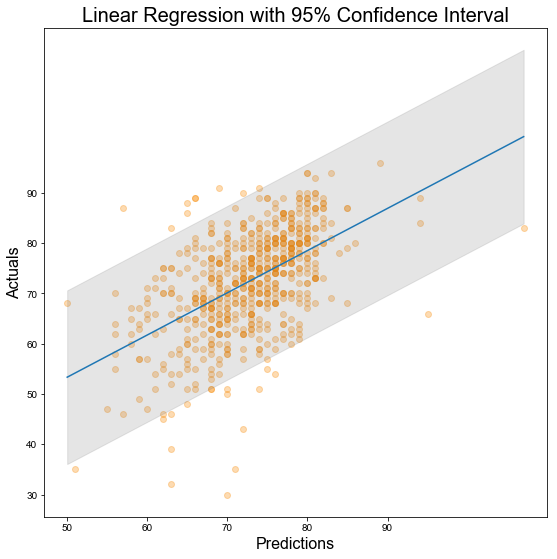

In [32]:
lin_plot(lr_preds, y_test, 'Linear Regression with 95% Confidence Interval')

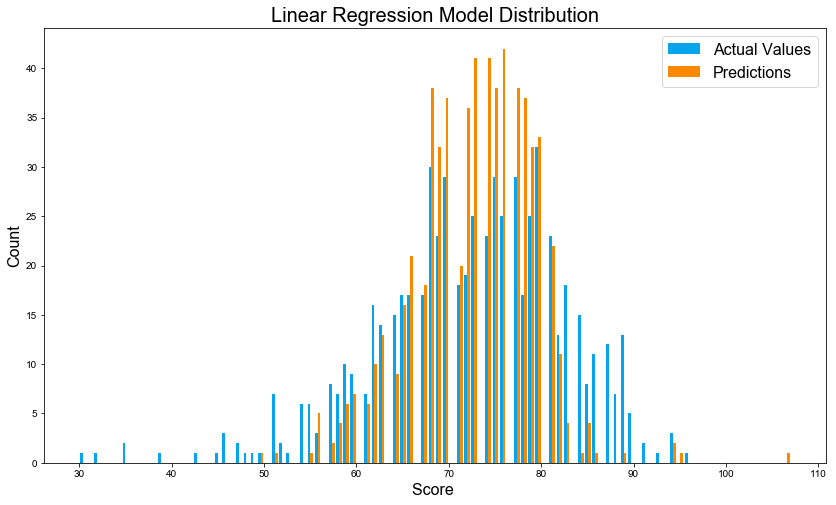

In [33]:
dist_hist(lr_preds, y_test, 'Linear Regression Model Distribution')

In [34]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state = RANDOM_STATE) #I am locking these boosting models with a random state and best params
ada_params = {
    'n_estimators': [50], #Lock to best-performing parameters after testing, without rewriting GridSearch cells
    'base_estimator__max_depth': [4],
    'learning_rate': [.01]
}
gs_ada = GridSearchCV(ada, param_grid=ada_params, cv=5)
gs_ada.fit(X_train, y_train)
ada_preds = gs_ada.predict(X_test).round()
gs_ada.best_params_

{'base_estimator__max_depth': 4, 'learning_rate': 0.01, 'n_estimators': 50}

In [35]:
get_scores(gs_ada, ada_preds)

Training Score:0.45522794719764337
Testing Score:0.27320704435783694
Test RMSE:8.639524883080739


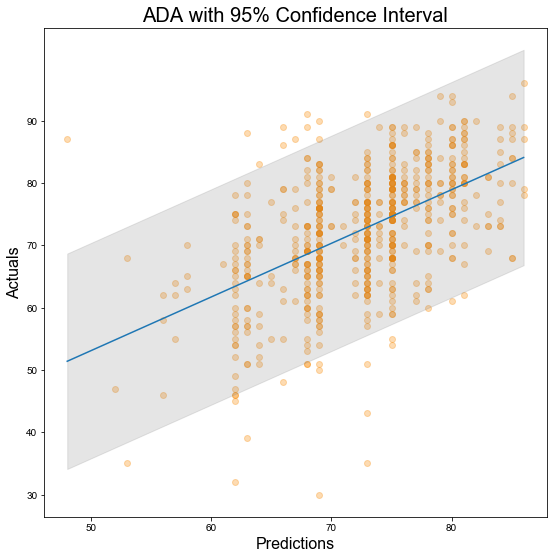

In [36]:
lin_plot(ada_preds, y_test, 'ADA with 95% Confidence Interval')

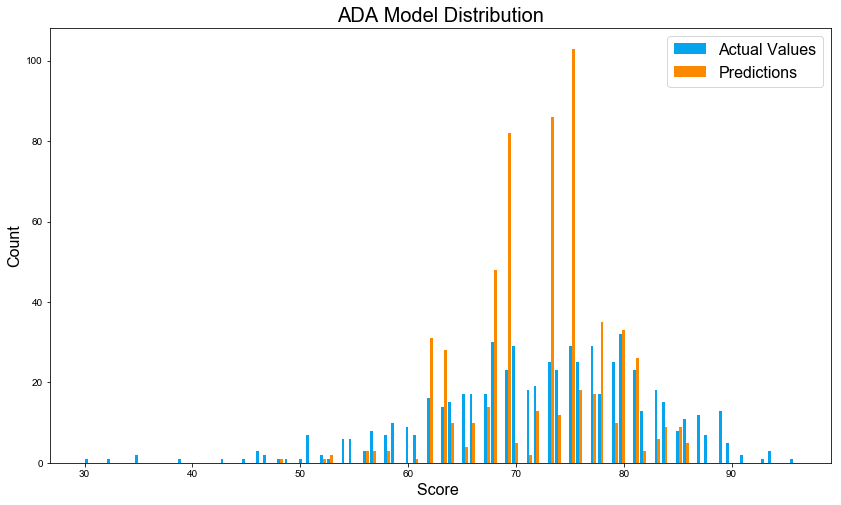

In [37]:
dist_hist(ada_preds, y_test, 'ADA Model Distribution')

In [38]:
grad = GradientBoostingRegressor(random_state = RANDOM_STATE)
grad_params = {
    'max_depth': [2], #Lock to best-performing parameters after testing, without rewriting GridSearch cells
    'n_estimators': [55],
    'learning_rate': [0.1]
}
gs_grad = GridSearchCV(grad, param_grid=grad_params, cv=5)
gs_grad.fit(X_train, y_train)
grad_preds = gs_grad.predict(X_test).round()
gs_grad.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 55}

In [39]:
get_scores(gs_grad, grad_preds)

Training Score:0.46843721819430917
Testing Score:0.3020416725875328
Test RMSE:8.460109911557876


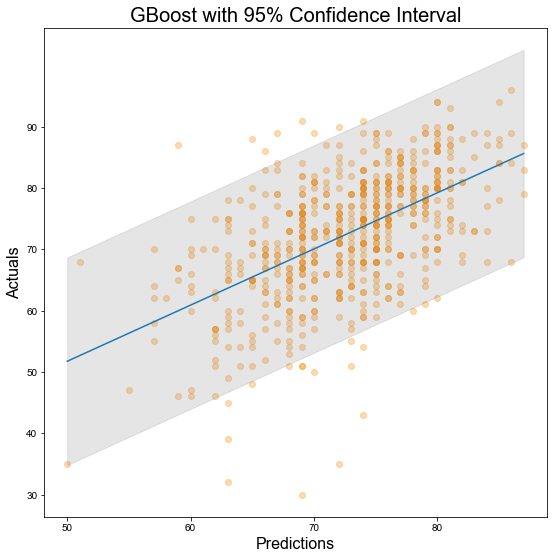

In [40]:
lin_plot(grad_preds, y_test, 'GBoost with 95% Confidence Interval')

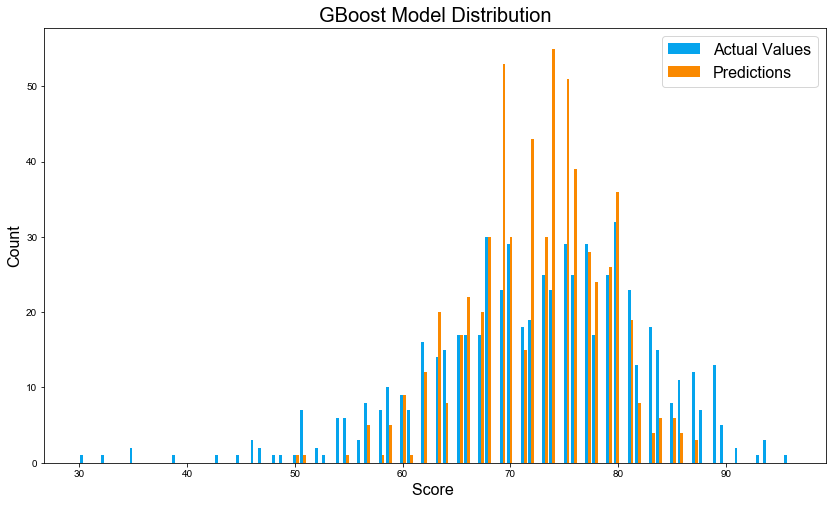

In [41]:
dist_hist(grad_preds, y_test, 'GBoost Model Distribution')

In [42]:
rf = RandomForestRegressor(random_state = RANDOM_STATE)
rf_params = {
    'n_estimators': [150], #Lock to best-performing parameters after testing, without rewriting GridSearch cells
    'max_depth': [3],
}
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs_rf.fit(X_train, y_train)
rf_preds = gs_rf.predict(X_test).round()
gs_rf.best_params_

{'max_depth': 3, 'n_estimators': 150}

In [43]:
get_scores(gs_rf, rf_preds)

Training Score:0.43310194889309594
Testing Score:0.260890456901535
Test RMSE:8.709820862846446


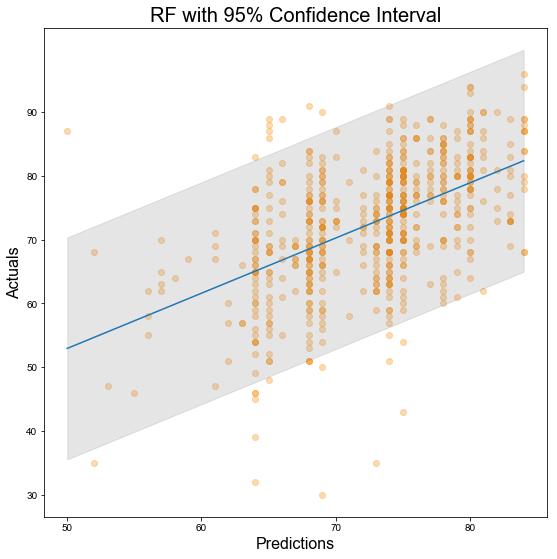

In [44]:
lin_plot(rf_preds, y_test, 'RF with 95% Confidence Interval')

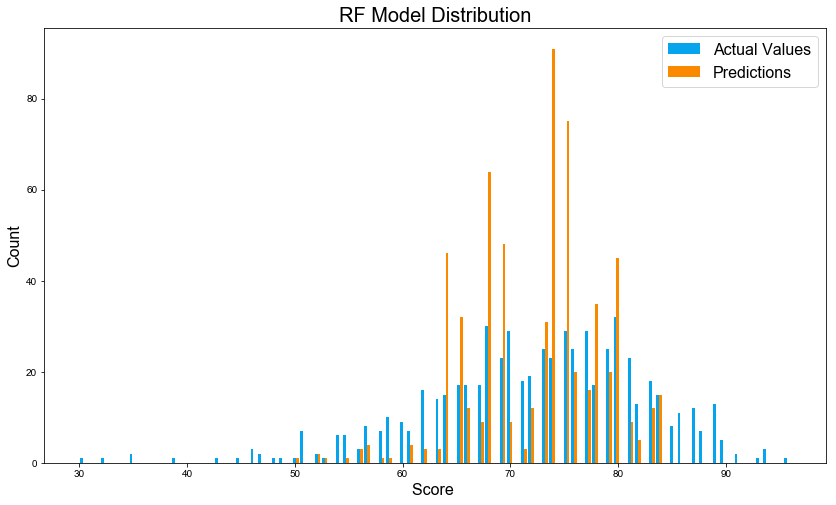

In [45]:
dist_hist(rf_preds, y_test, 'RF Model Distribution')

In [46]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [47]:
stepwise_selection(X_df, y)

Add  rating                         with p-value 1.97626e-323
Add  rating_ratio                   with p-value 6.02231e-12
Add  average_playtime               with p-value 1.7153e-05
Add  price                          with p-value 0.00180562


['rating', 'rating_ratio', 'average_playtime', 'price']

In [48]:
features2 = ['rating', 'rating_ratio', 'average_playtime', 'price']

In [49]:
X_df = df[features2]
y = df['meta_score']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.2, random_state = RANDOM_STATE
                                                   )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2531, 4), (633, 4), (2531,), (633,))

In [51]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test).round()

In [52]:
get_scores(lr, lr_preds)

Training Score:0.41139921904034316
Testing Score:0.2773856018360673
Test RMSE:8.605446675231494


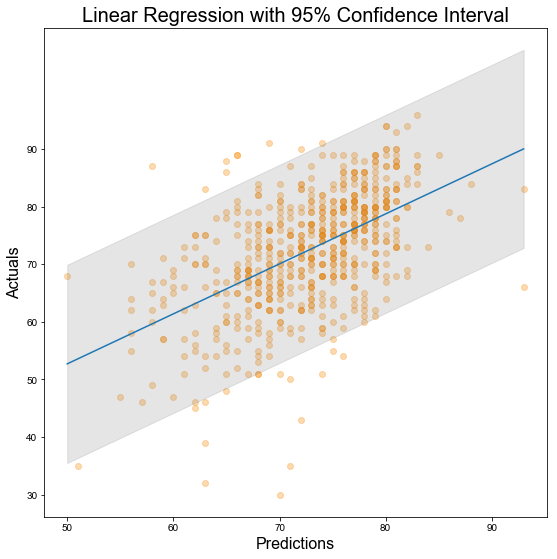

In [53]:
lin_plot(lr_preds, y_test, 'Linear Regression with 95% Confidence Interval')

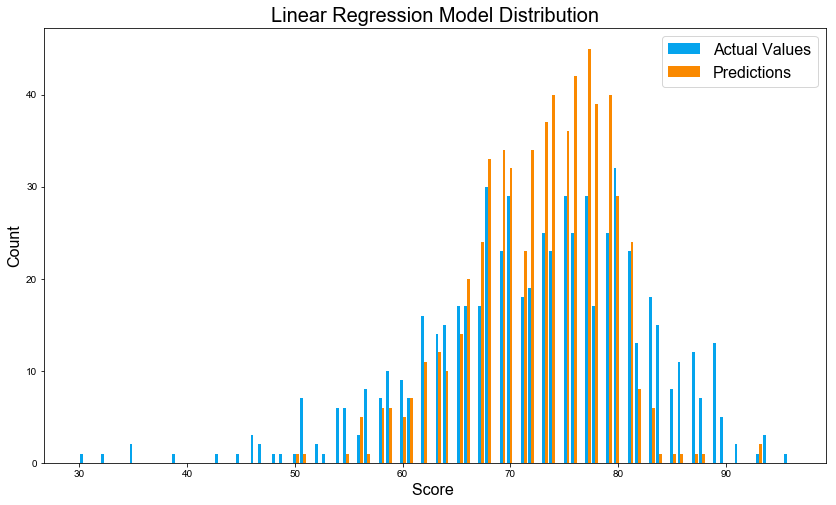

In [54]:
dist_hist(lr_preds, y_test, 'Linear Regression Model Distribution')

In [55]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state = RANDOM_STATE) #I am locking these boosting models with a random state and best params
ada_params = {
    'n_estimators': [60], #Lock to best-performing parameters after testing, without rewriting GridSearch cells
    'base_estimator__max_depth': [4],
    'learning_rate': [.01]
}
gs_ada = GridSearchCV(ada, param_grid=ada_params, cv=5)
gs_ada.fit(X_train, y_train)
ada_preds = gs_ada.predict(X_test).round()
gs_ada.best_params_

{'base_estimator__max_depth': 4, 'learning_rate': 0.01, 'n_estimators': 60}

In [56]:
get_scores(gs_ada, ada_preds)

Training Score:0.444301445684257
Testing Score:0.2693390226901514
Test RMSE:8.657061149195856


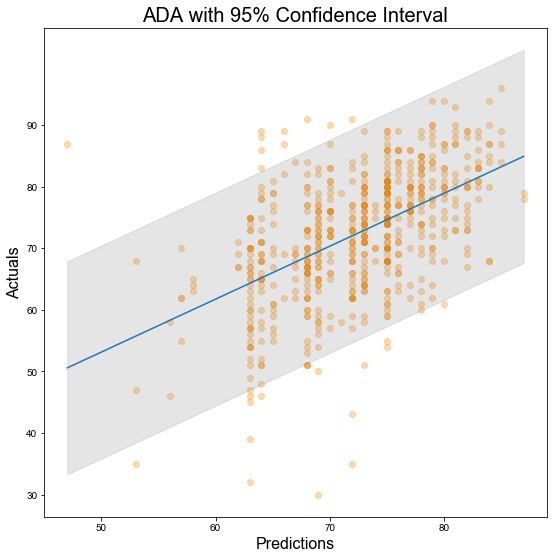

In [57]:
lin_plot(ada_preds, y_test, 'ADA with 95% Confidence Interval')

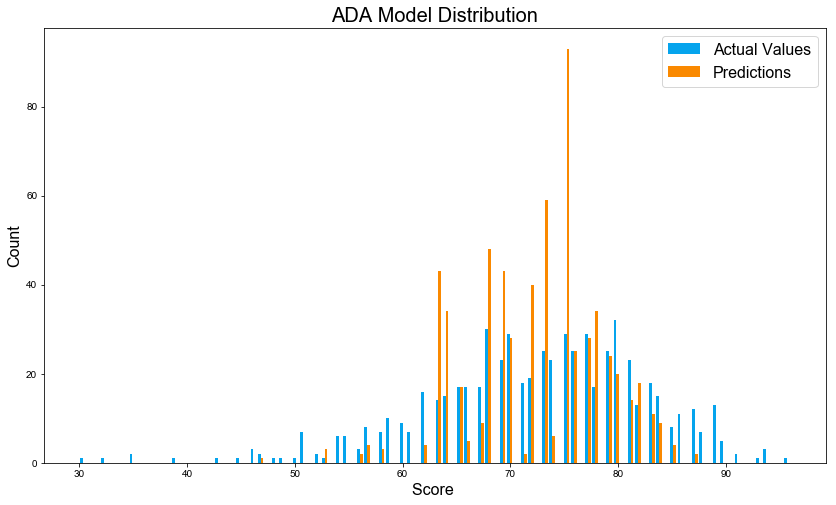

In [58]:
dist_hist(ada_preds, y_test, 'ADA Model Distribution')

In [59]:
grad = GradientBoostingRegressor(random_state = RANDOM_STATE)
grad_params = {
    'max_depth': [2], #Lock to best-performing parameters after testing, without rewriting GridSearch cells
    'n_estimators': [45],
    'learning_rate': [0.1]
}
gs_grad = GridSearchCV(grad, param_grid=grad_params, cv=5)
gs_grad.fit(X_train, y_train)
grad_preds = gs_grad.predict(X_test).round()
gs_grad.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 45}

In [60]:
get_scores(gs_grad, grad_preds)

Training Score:0.44639855092885206
Testing Score:0.28476649356833883
Test RMSE:8.588632775604417


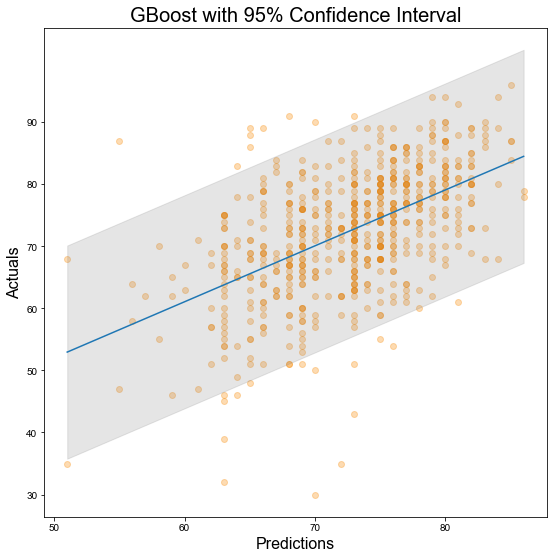

In [61]:
lin_plot(grad_preds, y_test, 'GBoost with 95% Confidence Interval')

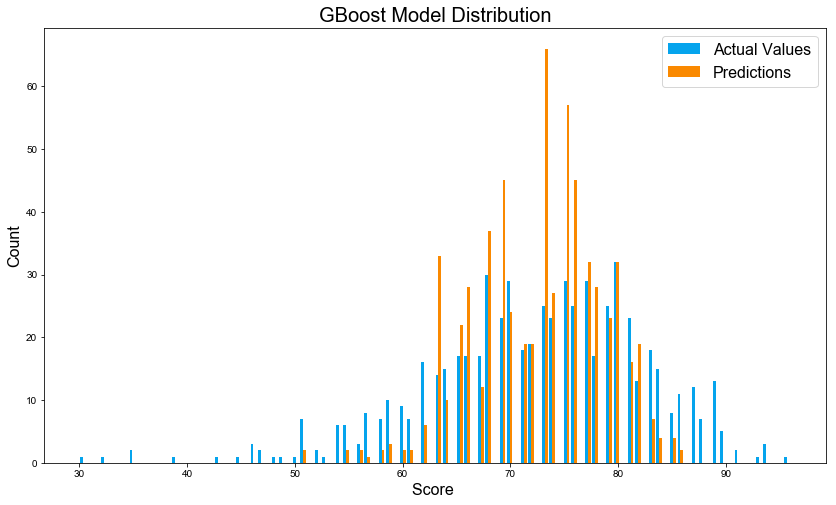

In [62]:
dist_hist(grad_preds, y_test, 'GBoost Model Distribution')

In [63]:
rf = RandomForestRegressor(random_state = RANDOM_STATE)
rf_params = {
    'n_estimators': [175], #Lock to best-performing parameters after testing, without rewriting GridSearch cells
    'max_depth': [4],
}
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs_rf.fit(X_train, y_train)
rf_preds = gs_rf.predict(X_test).round()
gs_rf.best_params_

{'max_depth': 4, 'n_estimators': 175}

In [64]:
get_scores(gs_rf, rf_preds)

Training Score:0.4539995137174656
Testing Score:0.2713823415837968
Test RMSE:8.67902266612886


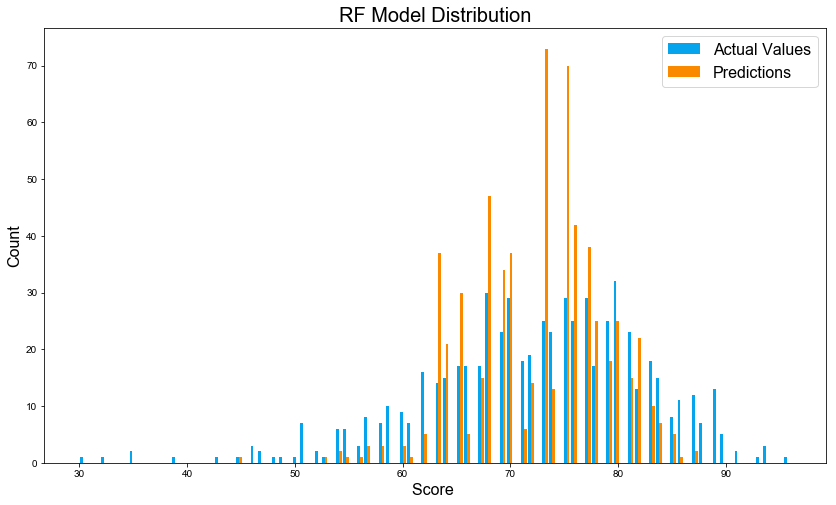

In [65]:
dist_hist(rf_preds, y_test, 'RF Model Distribution')

In [66]:
## Model Selection

In [67]:
steam_clean.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,0,159745,4173,21211,172,10000000-20000000,9.99
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,0,4335,771,798,11,2000000-5000000,4.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,4325,482,894,18,5000000-10000000,4.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Classic,0,1592,345,1200,8,5000000-10000000,4.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Classic,0,8907,477,1316,281,5000000-10000000,4.99


In [125]:
games_df = pre_process(steam_clean)

In [126]:
games_df['p_metacritic'] = gs_grad.predict(games_df[features2])

In [131]:
pred_metascore = gs_grad.predict(games_df[features2])

In [128]:
games_df.isnull().sum()

appid                    0
name                     0
release_date             0
developer                0
publisher                1
required_age             0
genres                   0
achievements             0
positive_ratings         0
negative_ratings         0
average_playtime         0
median_playtime          0
owners                   0
price                    0
total_ratings            0
rating_ratio             0
rating                   0
release_year             0
mods                     0
multi_player             0
online_co_op             0
online_multi_player      0
single_player            0
action                   0
adventure                0
casual                   0
early_access             0
indie                    0
massively_multiplayer    0
rpg                      0
racing                   0
simulation               0
sports                   0
strategy                 0
p_metacritic             0
dtype: int64

In [129]:
def dist_hist_pred(preds,title):
    plt.figure(figsize=(14,8))
    plt.hist(x = [preds],
            bins = 100,
            color = ['#fa8900'],
            label = ['Predictions'])
    plt.legend(fontsize=16)
    plt.title(f'{title}', fontsize=20)
    plt.xlabel('Score ', fontsize=16)
    plt.ylabel('Count', fontsize=16);

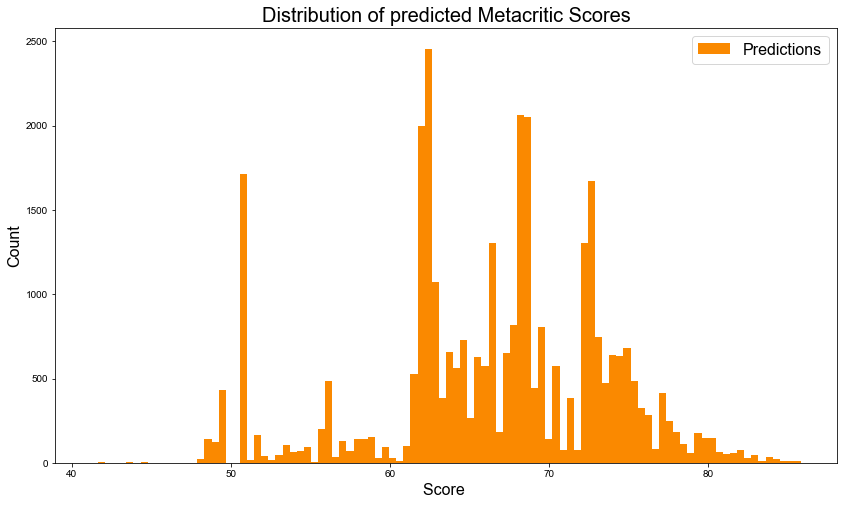

In [132]:
dist_hist_pred(games_df['p_metacritic'], 'Distribution of predicted Metacritic Scores')

In [134]:
games_df.head()

,appid,name,release_date,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,rating_ratio,rating,release_year,mods,multi_player,online_co_op,online_multi_player,single_player,action,adventure,casual,early_access,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy,p_metacritic
0,10,Counter-Strike,2000-11-01,Valve,Valve,0,Action,0,159745,4173,21211,172,10000000,9.99,163918,0.974542,96.141982,2000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,85.423725
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,0,Action,0,4335,771,798,11,2000000,4.99,5106,0.849001,81.652169,1999,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,76.355907
2,30,Day of Defeat,2003-05-01,Valve,Valve,0,Action,0,4325,482,894,18,5000000,4.99,4807,0.899730,86.467857,2003,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,78.662717
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,0,Action,0,1592,345,1200,8,5000000,4.99,1937,0.821890,77.979832,2001,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,74.989380
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,0,Action,0,8907,477,1316,281,5000000,4.99,9384,0.949169,91.893508,1999,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,82.020638


In [135]:
games_df['type'] = 'Free'
games_df.loc[games_df['price'] > 0, 'type'] = 'Paid'

In [136]:
games_df.columns

Index(['appid', 'name', 'release_date', 'developer', 'publisher',
       'required_age', 'genres', 'achievements', 'positive_ratings',
       'negative_ratings', 'average_playtime', 'median_playtime', 'owners',
       'price', 'total_ratings', 'rating_ratio', 'rating', 'release_year',
       'mods', 'multi_player', 'online_co_op', 'online_multi_player',
       'single_player', 'action', 'adventure', 'casual', 'early_access',
       'indie', 'massively_multiplayer', 'rpg', 'racing', 'simulation',
       'sports', 'strategy', 'p_metacritic', 'type'],
      dtype='object')

In [146]:
games_df.to_csv('games.csv')